In [1]:
from package_imports import *

In [7]:
data = pd.read_csv("../data/size_normalized_gait_features.csv", index_col=0)
data.reset_index(inplace= True)
data = data.drop('index', axis = 1)
data = data.drop(['tspeed_HSR', 'tspeed_MidSSR', 'tspeed_TOR', 'tspeed_HSL', 'tspeed_TOL', 'tspeed_MidSSL', 'Butterfly_y_abs', 'ButterflySQ_y', 'SS_L'], axis = 1)
#Creates a unique ID for each subject, since PID numbers aren't unique
data["id"] = data.PID.astype(str) + data.TrialID.astype(str)

In [17]:
#Generate graph with # of subjects lost per sequence length
def genarate_sequences(data, strides_per_sequence, skipped_steps):
    '''
    Function to generate sequence with features from multiple strides 
    Arguments:
        stride_per_sequence: Number of multiple strides to collect in a sequence 
        skipped_steps: Number of strides to skip when making the next sequence of stride_per_sequence group of strides 
        This is similar to a moving window of length stride_per_sequence that moves ahead skipped_steps each time 
    Returns:
        seqs: list of dataframes where each dataframe is a group of 10 strides with it's corresponding 
              21 gait features, PID, trialID, unique ID and label. Hence, each dataframe in seqs is shaped (10, 25). 
    
    '''
    row = 0
    nullseq = 0;
    id = data.loc[0, 'id']
    pid = data.loc[0, 'PID']
    seq_count = 0
    seqs = [] #List to collect grouped dataframes of multiple strides 

    while row < (data.shape[0] - strides_per_sequence):
        if data.loc[row, 'id'] == id and data.loc[row+strides_per_sequence, 'id'] == id:
            seq = data.iloc[row:row+strides_per_sequence].drop(['PID', 'Label', 'id'], axis = 1)
            if not seq.isnull().values.any():
                #print(type(data.iloc[row:row+strides_per_sequence]))
                seqs.append(data.iloc[row:row+strides_per_sequence])
                if (data.loc[row, 'id'] not in idswithseqs):
                     idswithseqs[data.loc[row, 'id']] = 0
                idswithseqs[data.loc[row, 'id']]+=1
                #idswithseqs.append(data.loc[row, 'id'])
                row +=skipped_steps
            else:
                nullseq+=1
                row+=1
            
        else:
            id = data.loc[row, 'id']
            pid = data.loc[row,'PID']
            row+=1
    
    print("dropped sequences: ", nullseq)
    #print(seqs)
    return seqs

In [37]:
possibleLengths = np.arange(20)
seqcounts = []
seqs = []
for i in possibleLengths:
    print("Sequence length: ",i)
    idswithseqs = {}
    seqs.append(genarate_sequences(data, i, 2))
    print(idswithseqs)
    print(len(idswithseqs))
    seqcounts.append(len(idswithseqs))

Sequence length:  0
dropped sequences:  0
{'2001': 23, '2011': 20, '2021': 23, '2031': 22, '2041': 28, '2051': 29, '2061': 24, '2071': 26, '2081': 25, '2091': 29, '2101': 29, '2111': 27, '2141': 32, '2151': 27, '2161': 32, '2171': 25, '2181': 27, '2191': 23, '3001': 21, '3011': 27, '3021': 29, '3031': 33, '3041': 24, '3051': 34, '3061': 23, '3071': 20, '3081': 31, '3121': 25, '3131': 19, '3141': 16, '3181': 7, '3201': 21, '3211': 20, '3221': 19, '3231': 31, '2002': 24, '2012': 19, '2022': 19, '2032': 23, '2042': 29, '2052': 29, '2062': 26, '2072': 27, '2082': 24, '2092': 23, '2102': 29, '2112': 24, '2142': 31, '2152': 26, '2162': 30, '2172': 25, '2182': 26, '2192': 28, '3002': 23, '3012': 29, '3022': 28, '3032': 32, '3042': 24, '3052': 32, '3062': 22, '3072': 19, '3082': 27, '3122': 27, '3132': 20, '3142': 11, '3182': 7, '3202': 25, '3212': 11, '3222': 10, '3232': 29}
70
Sequence length:  1
dropped sequences:  76
{'2001': 22, '2011': 20, '2021': 23, '2031': 20, '2041': 27, '2051': 27, 

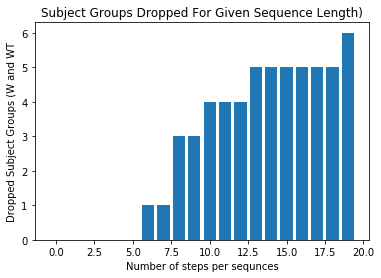

In [38]:
dropped = 70 - np.array(seqcounts)
plt.bar(x=possibleLengths, height=dropped)
plt.xlabel("Number of steps per sequnces")
plt.ylabel("Dropped Subject Groups (W and WT")
plt.title("Subject Groups Dropped For Given Sequence Length)")

plt.savefig("../results/data_plots/"+"Dropped_Groups_by_Seq_Length.png", dpi=350)

In [33]:
# Generate Graph with Strides for w and wt for each subject not including nulls
wstrides = {}
wtstrides = {}
#print(data.shape)
datanonan = data.dropna()
#print(datanonan.shape)
trials = datanonan.groupby('TrialID')

for i, dat in trials:
    PIDdata = dat.groupby('PID')
    for pid, d in PIDdata:
        if i == 1:
            wstrides[pid] = d.shape[0]
        if i == 2:
            wtstrides[pid] = d.shape[0]

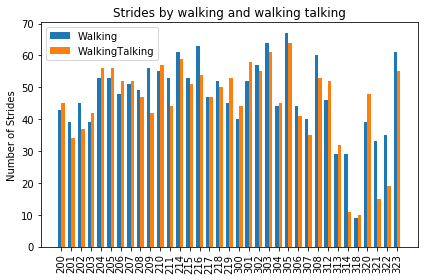

In [34]:
labels = np.array(list(wstrides.keys()))
walking = wstrides.values()
walkingtalking = wtstrides.values()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(np.array(x) - width/2, walking, width, label='Walking')
rects2 = ax.bar(np.array(x) + width/2, walkingtalking, width, label='WalkingTalking')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Strides')
ax.set_title('Strides by walking and walking talking')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

fig.tight_layout()
plt.savefig('../results/data_plots/' + '"Strides_by_walking_and_walking_talking.png', dpi = 350)
plt.show()

In [4]:
#Graph of subjects with sequences walking, subjects with sequences talking, amount of gened sequences walking and walking talking
#Data needed: per seq length: # of subjects walking, # of subjects talking, # of gened sequences walking, # of gened sequences talking 

"\nfor i, dat in trials:\n    PIDdata = dat.groupby('PID')\n    for pid, d in PIDdata:\n        if i == 1:\n            wstrides[pid] = d.shape[0]\n        if i == 2:\n            wtstrides[pid] = d.shape[0]\n"

In [5]:
#Generate graph with # of subjects lost per sequence length
def genarate_sequences(data, strides_per_sequence, skipped_steps):
    '''
    Function to generate sequence with features from multiple strides 
    Arguments:
        stride_per_sequence: Number of multiple strides to collect in a sequence 
        skipped_steps: Number of strides to skip when making the next sequence of stride_per_sequence group of strides 
        This is similar to a moving window of length stride_per_sequence that moves ahead skipped_steps each time 
    Returns:
        seqs: list of dataframes where each dataframe is a group of 10 strides with it's corresponding 
              21 gait features, PID, trialID, unique ID and label. Hence, each dataframe in seqs is shaped (10, 25). 
    
    '''
    row = 0
    nullseq = 0;
    id = data.loc[0, 'id']
    pid = data.loc[0, 'PID']
    seq_count = 0
    seqs = [] #List to collect grouped dataframes of multiple strides 

    while row < (data.shape[0] - strides_per_sequence):
        if data.loc[row, 'id'] == id and data.loc[row+strides_per_sequence, 'id'] == id:
            seq = data.iloc[row:row+strides_per_sequence].drop(['PID', 'Label', 'id'], axis = 1)
            if not seq.isnull().values.any():
                #print(type(data.iloc[row:row+strides_per_sequence]))
                seqs.append(data.iloc[row:row+strides_per_sequence])
                if (data.loc[row, 'id'] not in idswithseqs):
                     idswithseqs[data.loc[row, 'id']] = 0
                idswithseqs[data.loc[row, 'id']]+=1
                #idswithseqs.append(data.loc[row, 'id'])
                row +=skipped_steps
            else:
                nullseq+=1
                row+=1
            
        else:
            id = data.loc[row, 'id']
            pid = data.loc[row,'PID']
            row+=1
    
    #print("dropped sequences: ", nullseq)
    #print(seqs)
    return seqs

In [16]:
possibleLengths = np.arange(20);
wseqcounts = []
wtseqcounts = []
wseqs = []
wtseqs = []
for i in possibleLengths:
    for l, g in data.groupby('TrialID'):
        g.reset_index(inplace=True)
        #print(g.head())
        #print("Sequence length: ",i)
        idswithseqs = {}
        seqs = genarate_sequences(g, i, 2)
        if l == 1:
            #walking
            wseqcounts.append(len(idswithseqs))
            wseqs.append(len(seqs))
        if l == 2:
            #walking talking
            wtseqcounts.append(len(idswithseqs))
            wtseqs.append(len(seqs))
        #print(idswithseqs)
        #print(len(idswithseqs))
        #seqcounts.append(len(idswithseqs))

dropped sequences:  0
dropped sequences:  0
dropped sequences:  41
dropped sequences:  36
dropped sequences:  59
dropped sequences:  81
dropped sequences:  83
dropped sequences:  94
dropped sequences:  94
dropped sequences:  109
dropped sequences:  113
dropped sequences:  113
dropped sequences:  120
dropped sequences:  119
dropped sequences:  131
dropped sequences:  120
dropped sequences:  137
dropped sequences:  121
dropped sequences:  141
dropped sequences:  122
dropped sequences:  145
dropped sequences:  121
dropped sequences:  147
dropped sequences:  122
dropped sequences:  151
dropped sequences:  119
dropped sequences:  153
dropped sequences:  120
dropped sequences:  156
dropped sequences:  117
dropped sequences:  155
dropped sequences:  118
dropped sequences:  158
dropped sequences:  116
dropped sequences:  157
dropped sequences:  116
dropped sequences:  158
dropped sequences:  114
dropped sequences:  155
dropped sequences:  114


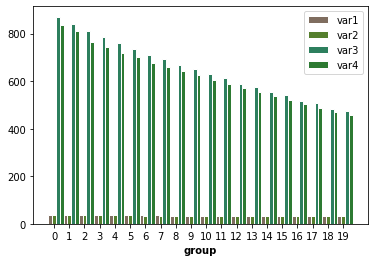

In [17]:
#Graph will all 4, doesn't work well

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = wseqcounts
bars2 = wtseqcounts
bars3 = wseqs
bars4 = wtseqs
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='var2')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
plt.bar(r4, bars4, color='#2d7a32', width=barWidth, edgecolor='white', label='var4')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], np.arange(20))
 
# Create legend & Show graphic
plt.legend()
plt.show()


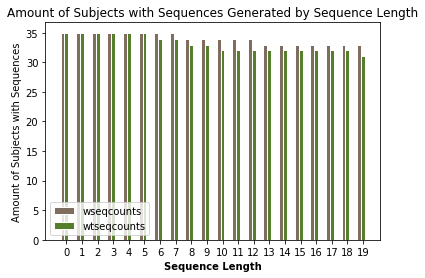

In [31]:
#Amount of Subjects with Sequences Generated by Sequence Length

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = wseqcounts
bars2 = wtseqcounts
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='wseqcounts')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='wtseqcounts')
 
# Add xticks on the middle of the group bars
plt.xlabel('Sequence Length', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], np.arange(20))
plt.title("Amount of Subjects with Sequences Generated by Sequence Length")
plt.ylabel("Amount of Subjects with Sequences")
 
 
# Create legend & Show graphic
plt.legend(loc = "lower left")
plt.savefig('../results/data_plots/' + '"Amount_of_Subjects_with_Sequences_Generated_by_Sequence_Length.png', dpi = 350)
plt.show()


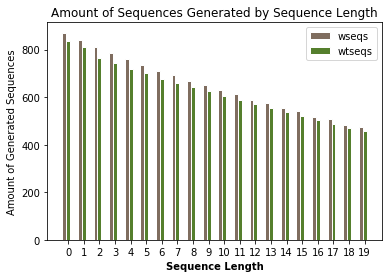

In [30]:
#Amount of Sequences Generated by Sequence Length

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = wseqs
bars2 = wtseqs
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='wseqs')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='wtseqs')
 
# Add xticks on the middle of the group bars
plt.xlabel('Sequence Length', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], np.arange(20))
plt.title("Amount of Sequences Generated by Sequence Length")
plt.ylabel("Amount of Generated Sequences")
 
# Create legend & Show graphic
plt.legend()
plt.savefig('../results/data_plots/' + 'Amount_of_Sequences_Generated_by_Sequence_Length.png', dpi = 350)
plt.show()
